In [1]:
import pandas as pd 
import numpy as np 


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns 


In [3]:
sns.set(rc={'figure.figsize': (9,6)})

In [4]:
events_data = pd.read_csv('C:\Python_tasks\stepic\data\event_data_train.csv')


In [5]:
submission_data = pd.read_csv('C:\Python_tasks\stepic\data\submissions_data_train.csv')

# Предобработка

In [6]:
def create_date_and_day(df):
    df.copy()
    return df.assign(date = lambda x: pd.to_datetime(df['timestamp'], unit='s'),
                     day = lambda x: pd.to_datetime(df['timestamp'], unit='s').dt.date)

In [7]:
events_data = events_data.pipe(create_date_and_day)
submission_data = submission_data.pipe(create_date_and_day)

In [8]:
display(events_data.head())
submission_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [10]:
users_event_data = (events_data.pivot_table(index='user_id', #считаем количество разных действий для каждого юзера
                                            columns='action', 
                                            values='step_id', 
                                            aggfunc='count', 
                                            fill_value=0)
                               .reset_index()
                   )

In [11]:
users_score = (submission_data.pivot_table(index='user_id', # считаем количество разных статусов для каждого юзера
                                          columns='submission_status', 
                                          values='step_id', 
                                          aggfunc='count', fill_value=0)
                              .reset_index()
              )

In [12]:
display(users_event_data.head())
users_score.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [13]:

gap_data = (events_data[['user_id', 'day', 'timestamp']]
            .drop_duplicates(subset=['user_id', 'day'])
            .groupby('user_id')['timestamp']
            .apply(list)
            .apply(np.diff)
            .values
) # для каждого юзера находим разницу по времени между выполнением заданий
gap_data = pd.Series(np.concatenate(gap_data, axis=0)) # объеденим и переведем полученные значения в Series
gap_data = gap_data / (24 * 60 * 60) # переведем значения к количеству дней


<AxesSubplot:>

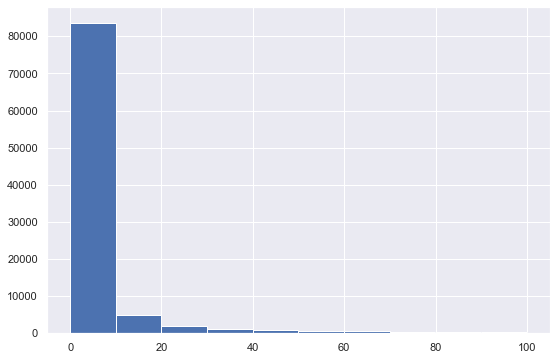

In [16]:
gap_data[gap_data < 100].hist() # посмотрим на распределение разницы между действиями пользователей

Видно, что большинство пользователей совершают последовательные действия на курсе с перерывами не превышающими 10-15 дней.
Для целей нашей задачи, в качестве пользователя, который перестал выполнять задания на курсе будем считать время перерыва равное 30 дням.

In [17]:
dropout_treshold = 30 * 24 * 60 * 60 # запишем в переменную временную отсечку, после которой будем считать пользователя покинувшим курс
last_timestamp = 1526772811 # в переменную запишем максимальный таймстемп

Сформируем таблицу с данными по каждому пользователю

In [19]:
user_data = (events_data.groupby('user_id', as_index=False)
             .agg({'timestamp':'max'})
             .rename(columns={'timestamp':'timestamp_last'})
             .assign(is_gone_user = lambda x: (last_timestamp - x['timestamp_last']) > dropout_treshold)
             .merge(users_score, how='outer')
             .fillna(0)
             .merge(users_event_data, how='outer')
             .merge(events_data.groupby('user_id')['day']
                    .nunique()
                    .to_frame()
                    .reset_index()
                    .rename(columns={'day':'user_days'}),
                   on='user_id',
                   how='outer')
             .assign(passed_course = lambda x: x['passed'] > 170)
            )

In [20]:
user_data.head()

,user_id,timestamp_last,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,user_days,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [55]:
display(user_data.groupby('passed_course').count())
display(user_data.passed_course.value_counts(normalize=True))

,user_id,timestamp_last,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,user_days,min_timestamp
passed_course,,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


False    0.925912
True     0.074088
Name: passed_course, dtype: float64

Только 7,4 % записавшихся на курс успешно его завершили.

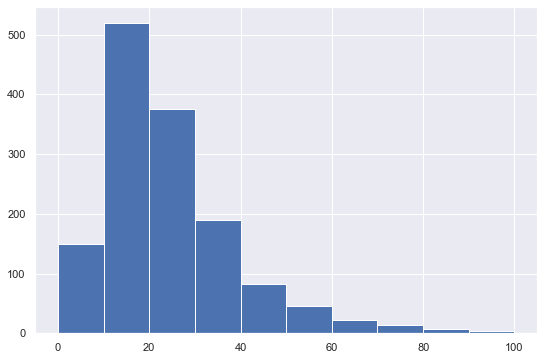

In [69]:
user_data[user_data['passed_course']].user_days.hist(range=(0,100))
plt.show()

На графике видно, что чаще всего курс заканчивают за 15-20 дней дальше с увеличением срока падает количество закончивших курс.

### Поиск паттернов поведения людей, успешно закончивших курс
Нам нужно отобрать дейсвтвия пользователя в первые три дня, чтобы потом можно было предсказать какое поведение ведет к завершению курса. Для этого вернемся к исходному датафрейму events_data

In [24]:
# создадим датафрейм, где для каждого юзера будет проставлено время его первого действия на площадке
user_min_time = (events_data.groupby('user_id')
                            .agg({'timestamp':'min'})\
                            .rename({'timestamp':'min_timestamp'}, axis=1)
                 .reset_index()
                )

In [25]:
# добавим колонку к датафрейму со всеми данными юзеров
user_data = user_data.merge(user_min_time, on='user_id', how='outer')

Следующей задачей необходимо отфильтровать все действия пользователя в первые три дня.

In [27]:
# заведем переменную равную трем дням
learning_time_treshold = 3 * 24 * 60 * 60

In [28]:
# добавим в исходный датафрейм колонку в которой объедениним юзер айди и таймстемп как строку
events_data['user_time'] = events_data['user_id'].map(str) + '_' + events_data['timestamp'].map(str)

In [29]:
user_learning_time_treshold = user_min_time['user_id'].map(str) + '_' + (user_min_time['min_timestamp'] + learning_time_treshold).map(str)

In [30]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

In [31]:
user_min_time.head()

,user_id,min_timestamp,user_learning_time_treshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [32]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')

In [33]:
events_data_train = events_data[events_data['user_time'] <= events_data['user_learning_time_treshold']]

In [58]:
display(events_data_train.head())
events_data_train['user_id'].nunique()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


19234

In [35]:
# получилось отфильтровать датафрейм в котором собраны данные о юзерах только за три дня.
events_data_train.groupby('user_id')['day'].nunique().max()

4

### Поиск интересных событий

In [36]:
#найдем степ на котором отваливается большевсего пользователей.
submission_data_check = submission_data.merge(user_data[['user_id', 'timestamp_last']], how='outer')

In [37]:
# вот таким образом найден этот степ
(submission_data_check[submission_data_check['submission_status '] == 'wrong']
 .groupby('step_id')['user_id']
 .count()
 .sort_values(ascending=False)
 .head())

step_id
31978.0    16084
32031.0    13373
32202.0    13002
33481.0    10300
32075.0    10003
Name: user_id, dtype: int64

In [38]:
submission_data['user_time'] = submission_data['user_id'].map(str) + "_" + submission_data['timestamp'].map(str)
submission_data = submission_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submission_data_train = submission_data[submission_data['user_time'] <= submission_data['user_learning_time_treshold']]
submission_data_train.groupby('user_id').day.nunique().max()b

4

In [74]:
submission_data_train['user_id'].nunique()

8913

In [39]:
X = (submission_data_train.groupby('user_id')
                          .day.nunique()
                          .to_frame()
                          .reset_index()
                          .rename(columns={'day':'days'})
    )

In [40]:
steps_tried = (submission_data_train.groupby('user_id')
                                    .step_id.nunique()
                                    .to_frame()
                                    .reset_index()
                                    .rename(columns={'step_id':'steps_tried'})
              )

In [41]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [42]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [43]:
X.shape

(8913, 3)

In [44]:
X = X.merge(submission_data_train.pivot_table(index='user_id', 
                                          columns='submission_status', 
                                          values='step_id', 
                                          aggfunc='count', fill_value=0).reset_index(), on='user_id', how='outer')

In [45]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [46]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                                         columns='action',
                                         values='step_id',
                                         aggfunc='count', fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [47]:
X = X.fillna(0)

In [48]:
X = X.merge(user_data[['user_id', 'passed_course', 'is_gone_user']], on='user_id', how='outer')

In [49]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [50]:
X.groupby(['is_gone_user', 'passed_course'])['user_id'].count()

is_gone_user  passed_course
False         True               141
True          False            16560
              True              1284
Name: user_id, dtype: int64

In [51]:
y = X.passed_course.map(int)

In [52]:
X = X.drop(['is_gone_user', 'passed_course'], axis=1)

In [53]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [62]:
X.shape

(17985, 6)

In [60]:
display(X.head())
y

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


0        0
1        0
2        0
3        0
4        1
        ..
19229    0
19230    1
19231    0
19232    0
19233    0
Name: passed_course, Length: 17985, dtype: int64